# Capture the turn over point

in this notebook, I will try to dev a code that could help me capture the turn_over point in the evolutionary tracks so that we could find where is the zero-age-main-sequence

In [1]:
import numpy as np
import pandas as pd

import os, sys, tqdm, copy

import tqdm
import tqdm.notebook

import matplotlib.pyplot as plt
import matplotlib

style = [
    'seaborn-ticks',
    {
        'figure.dpi': 300,
        'font.size': 12,
        'image.cmap': 'inferno',
        'font.family': 'serif',
        'font.serif': ['Times', 'Times New Roman'] + plt.rcParams['font.serif'],
        'xtick.top': True,
        'xtick.direction': 'in',
        'ytick.right': True,
        'ytick.direction': 'in',
        'mathtext.fontset': 'cm'
        }]
plt.style.use(style)

# import scipy.io

# github_dir = '/home/dingshandeng/github/ysoisochrone/'
github_dir = '/Users/dingshandeng/github/ysoisochrone/'

os.chdir(os.path.join(github_dir, 'tests'))
sys.path.append(os.path.join(github_dir))

# import ysoisochrone.utils as utils
# import ysoisochrone.bayesian as bayesian
# import ysoisochrone.plotting as plotting
import ysoisochrone

## We use Baraffe tracks as a good start point

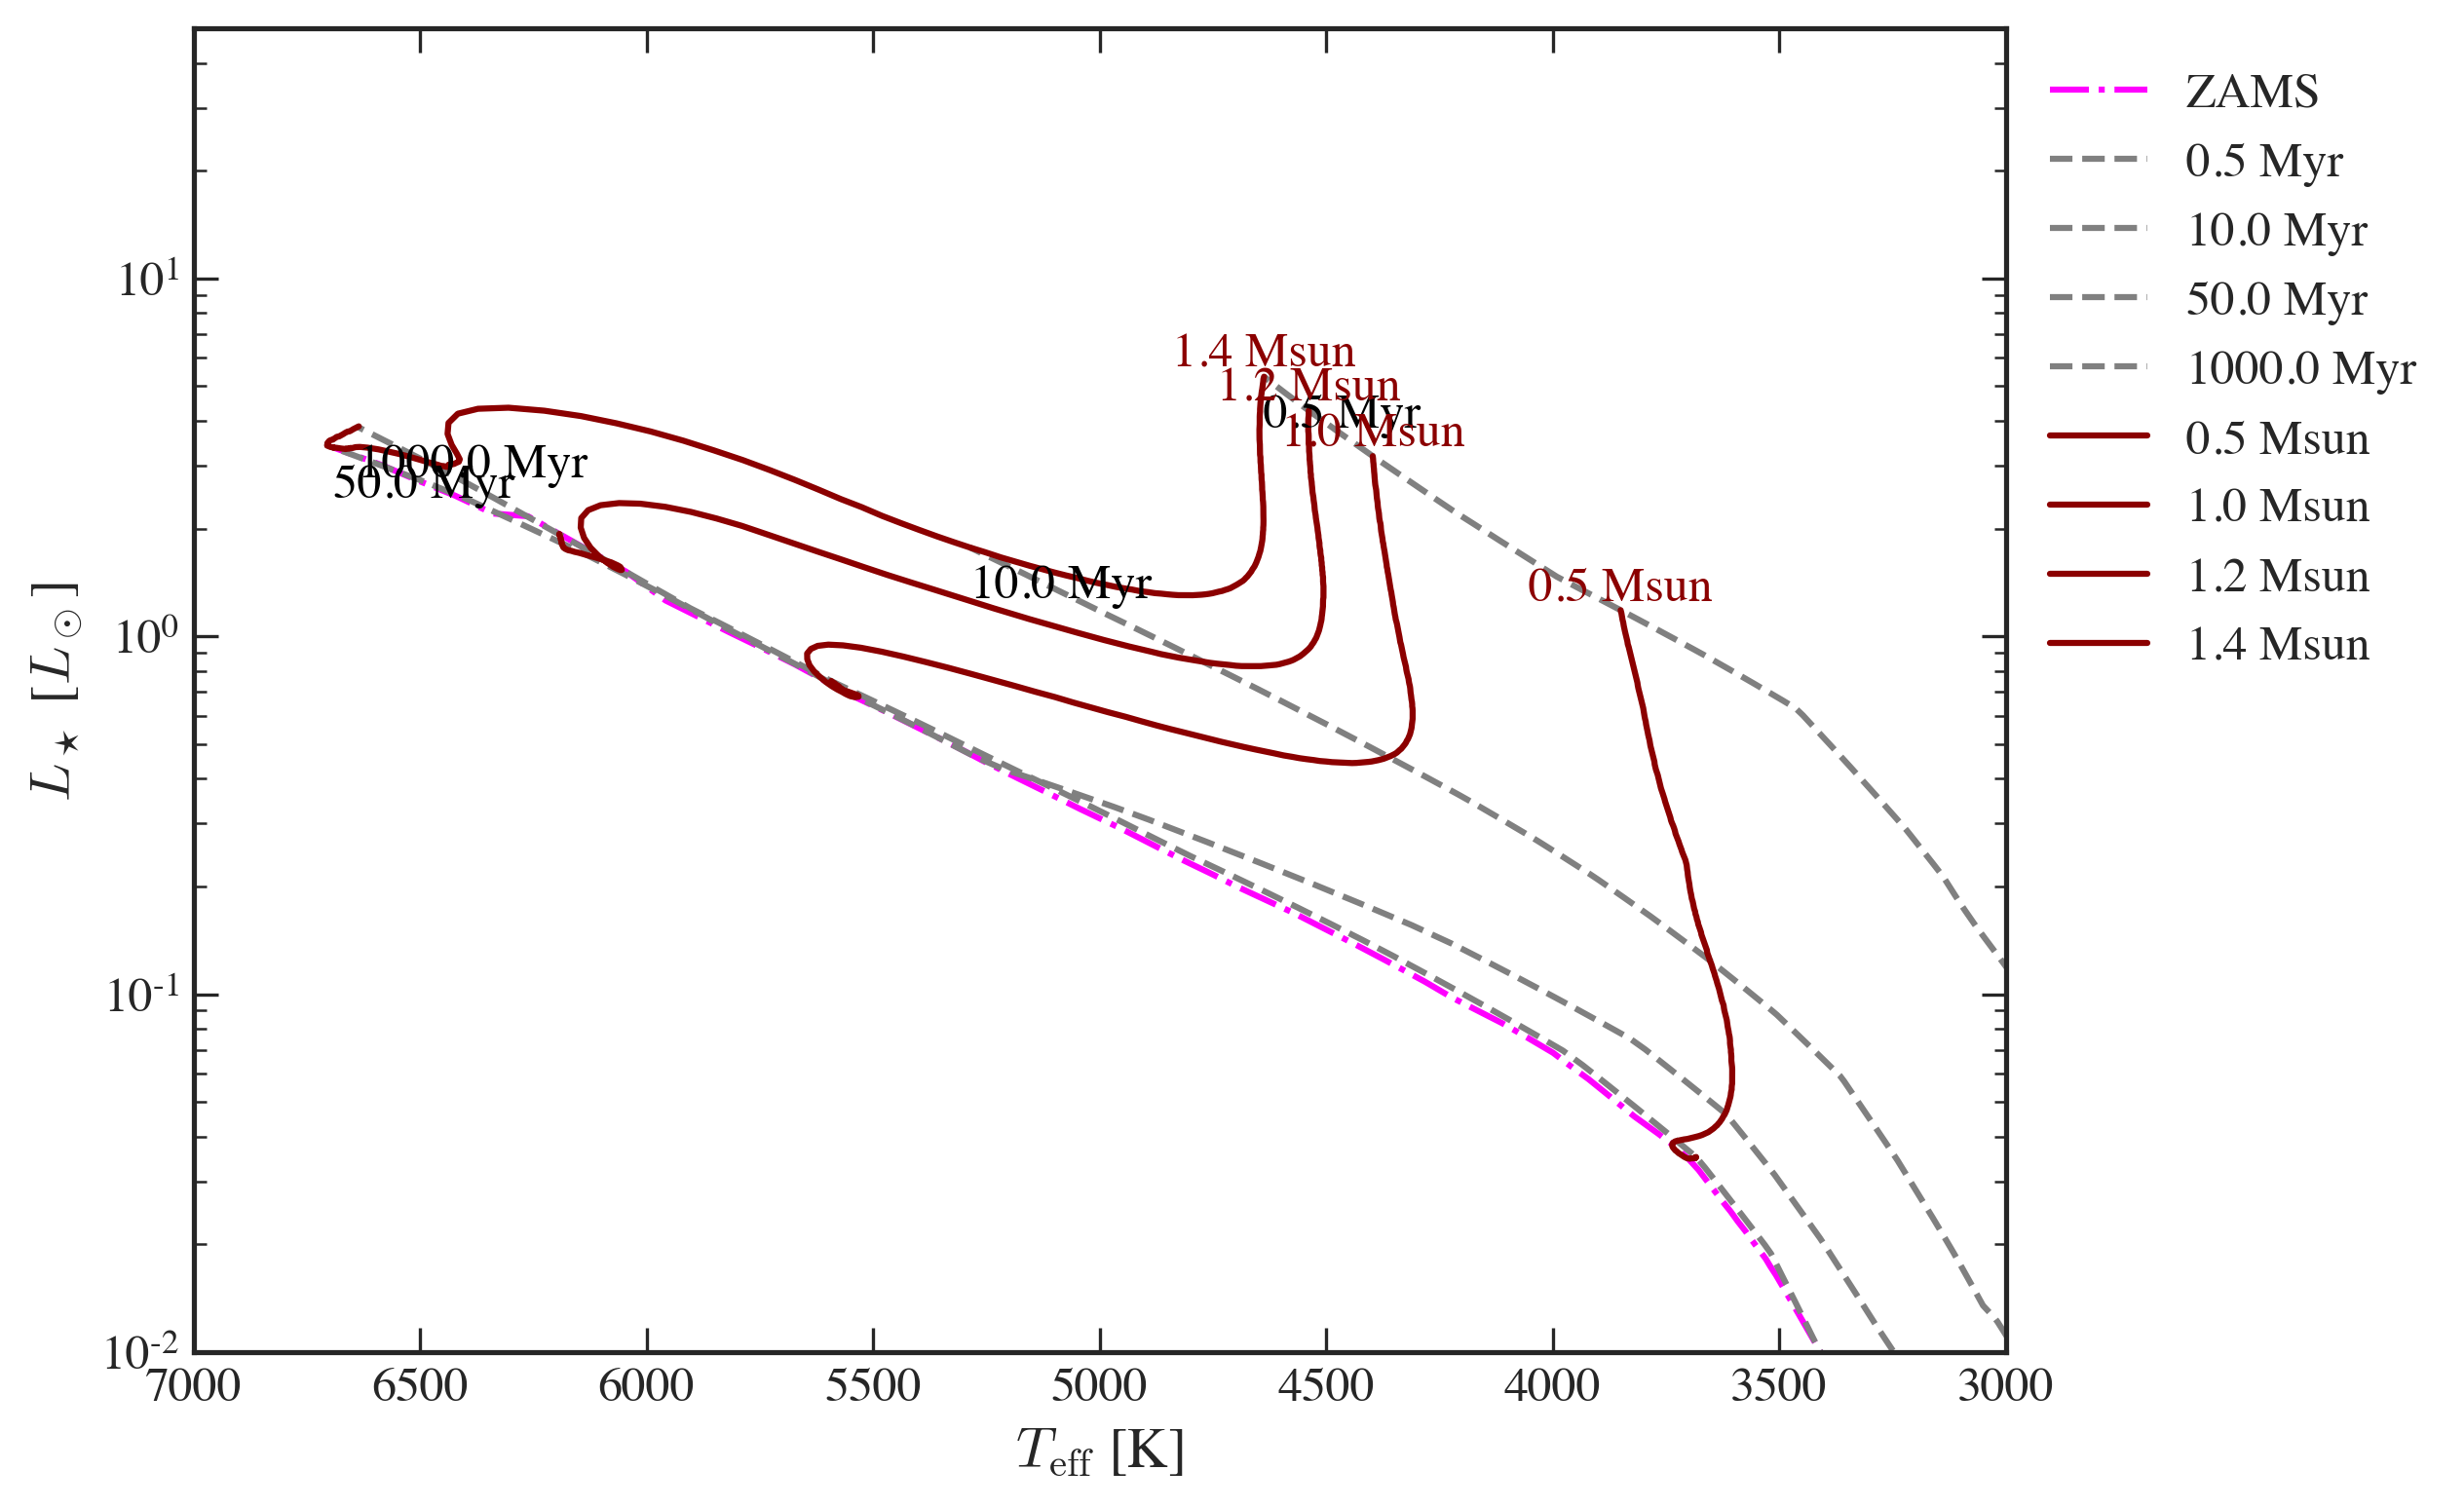

In [2]:
# Initialize the isochrone class with default data directory
isochrone = ysoisochrone.isochrone.Isochrone()

# isochrone.set_tracks('Baraffe2015')

mat_file_dir = './isochrones_data/Baraffe_AgeMassGrid_YSO_up1Gyr_matrix.mat'
isochrone.set_tracks('customize', load_file=mat_file_dir)

fig, ax = plt.subplots(figsize=(8, 6))

# # find the ZAMS
# teff_zams, lum_zams, mask_pms = ysoisochrone.utils.find_zams_curve(isochrone)

# # Plot ZAMS curve
# ax.plot(teff_zams, lum_zams, 'b-', label='ZAMS')

# ysoisochrone.plotting.plot_hr_diagram(isochrone, ax_set=ax, 
#                                       ages_to_plot=[0.5e6, 1.0e6, 2.0e6, 3.0e6, 5.0e6, 10.0e6, 30.0e6, 100.0e6], 
#                                       masses_to_plot=[0.2, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.39],
#                                       xlim_set=[6000, 3000], ylim_set=[0.01, 50.0])

ysoisochrone.plotting.plot_hr_diagram(isochrone, ax_set=ax, 
                                      ages_to_plot=[0.5e6, 10.0e6, 50.0e6, 1000.0e6], 
                                      masses_to_plot=[0.5, 1.0, 1.2, 1.39],
                                      xlim_set=[7000, 3000], ylim_set=[0.01, 50.0], 
                                      zams_curve=True)

# ax.set_xlim(6000, 2800)
# ax.set_ylim(0.005, 50)
plt.show()

## How about PARSEC

In [3]:
from ysoisochrone import utils

# data_points = utils.read_parsec_v2p0_tab_file(parsec_dir='./isochrones_data/PARSECv2p0/VAR_ROT0.00_SH_Z0.014_Y0.273/')

# # Create meshgrid and interpolate the data onto the grid
# # masses_i, log_age_i, logtlogl_grid, _, _ = utils.create_meshgrid(data_points)
# masses_i, log_age_i, logtlogl_grid, masses_grid, log_age_grid = utils.create_meshgrid(data_points)

# output_mat_file = os.path.join('isochrones_data', 'PARSECv2p0_AgeMassGrid_YSO_refrained_matrix.mat')

# # Save the parsed data to a .mat file
# utils.save_as_mat(masses_i, log_age_i, logtlogl_grid, output_mat_file)
# print(f"File saved as: {output_mat_file}")

# # set tracks
# isochrone = ysoisochrone.isochrone.Isochrone()
# mat_file_dir = output_mat_file

# isochrone.set_tracks('customize', load_file=mat_file_dir)

# # find the ZAMS
# teff_zams, lum_zams, mask_pms = utils.find_zams_curve(isochrone)

# output_mat_file = os.path.join('isochrones_data', 'PARSECv2p0_AgeMassGrid_YSO_refrained_masked_matrix.mat')

# logtlogl_grid[:, :, 0] *= mask_pms
# logtlogl_grid[:, :, 1] *= mask_pms

# # Save the parsed data to a .mat file
# utils.save_as_mat(masses_i, log_age_i, logtlogl_grid, output_mat_file)
# print(f"File saved as: {output_mat_file}")

In [9]:
# Initialize the isochrone class with default data directory
isochrone = ysoisochrone.isochrone.Isochrone()

# set tracks
# isochrone.set_tracks('PARSEC_v2p0')
isochrone.set_tracks('Feiden2016')

# # set tracks
# isochrone = ysoisochrone.isochrone.Isochrone()
# mat_file_dir = './isochrones_data/PARSECv2p0_AgeMassGrid_YSO_refrained_matrix.mat'
# # mat_file_dir = './isochrones_data/PARSECv2p0_AgeMassGrid_YSO_refrained_masked_matrix.mat'
# isochrone.set_tracks('customize', load_file=mat_file_dir)

# find the ZAMS
teff_zams, lum_zams, mask_pms = utils.find_zams_curve(isochrone)

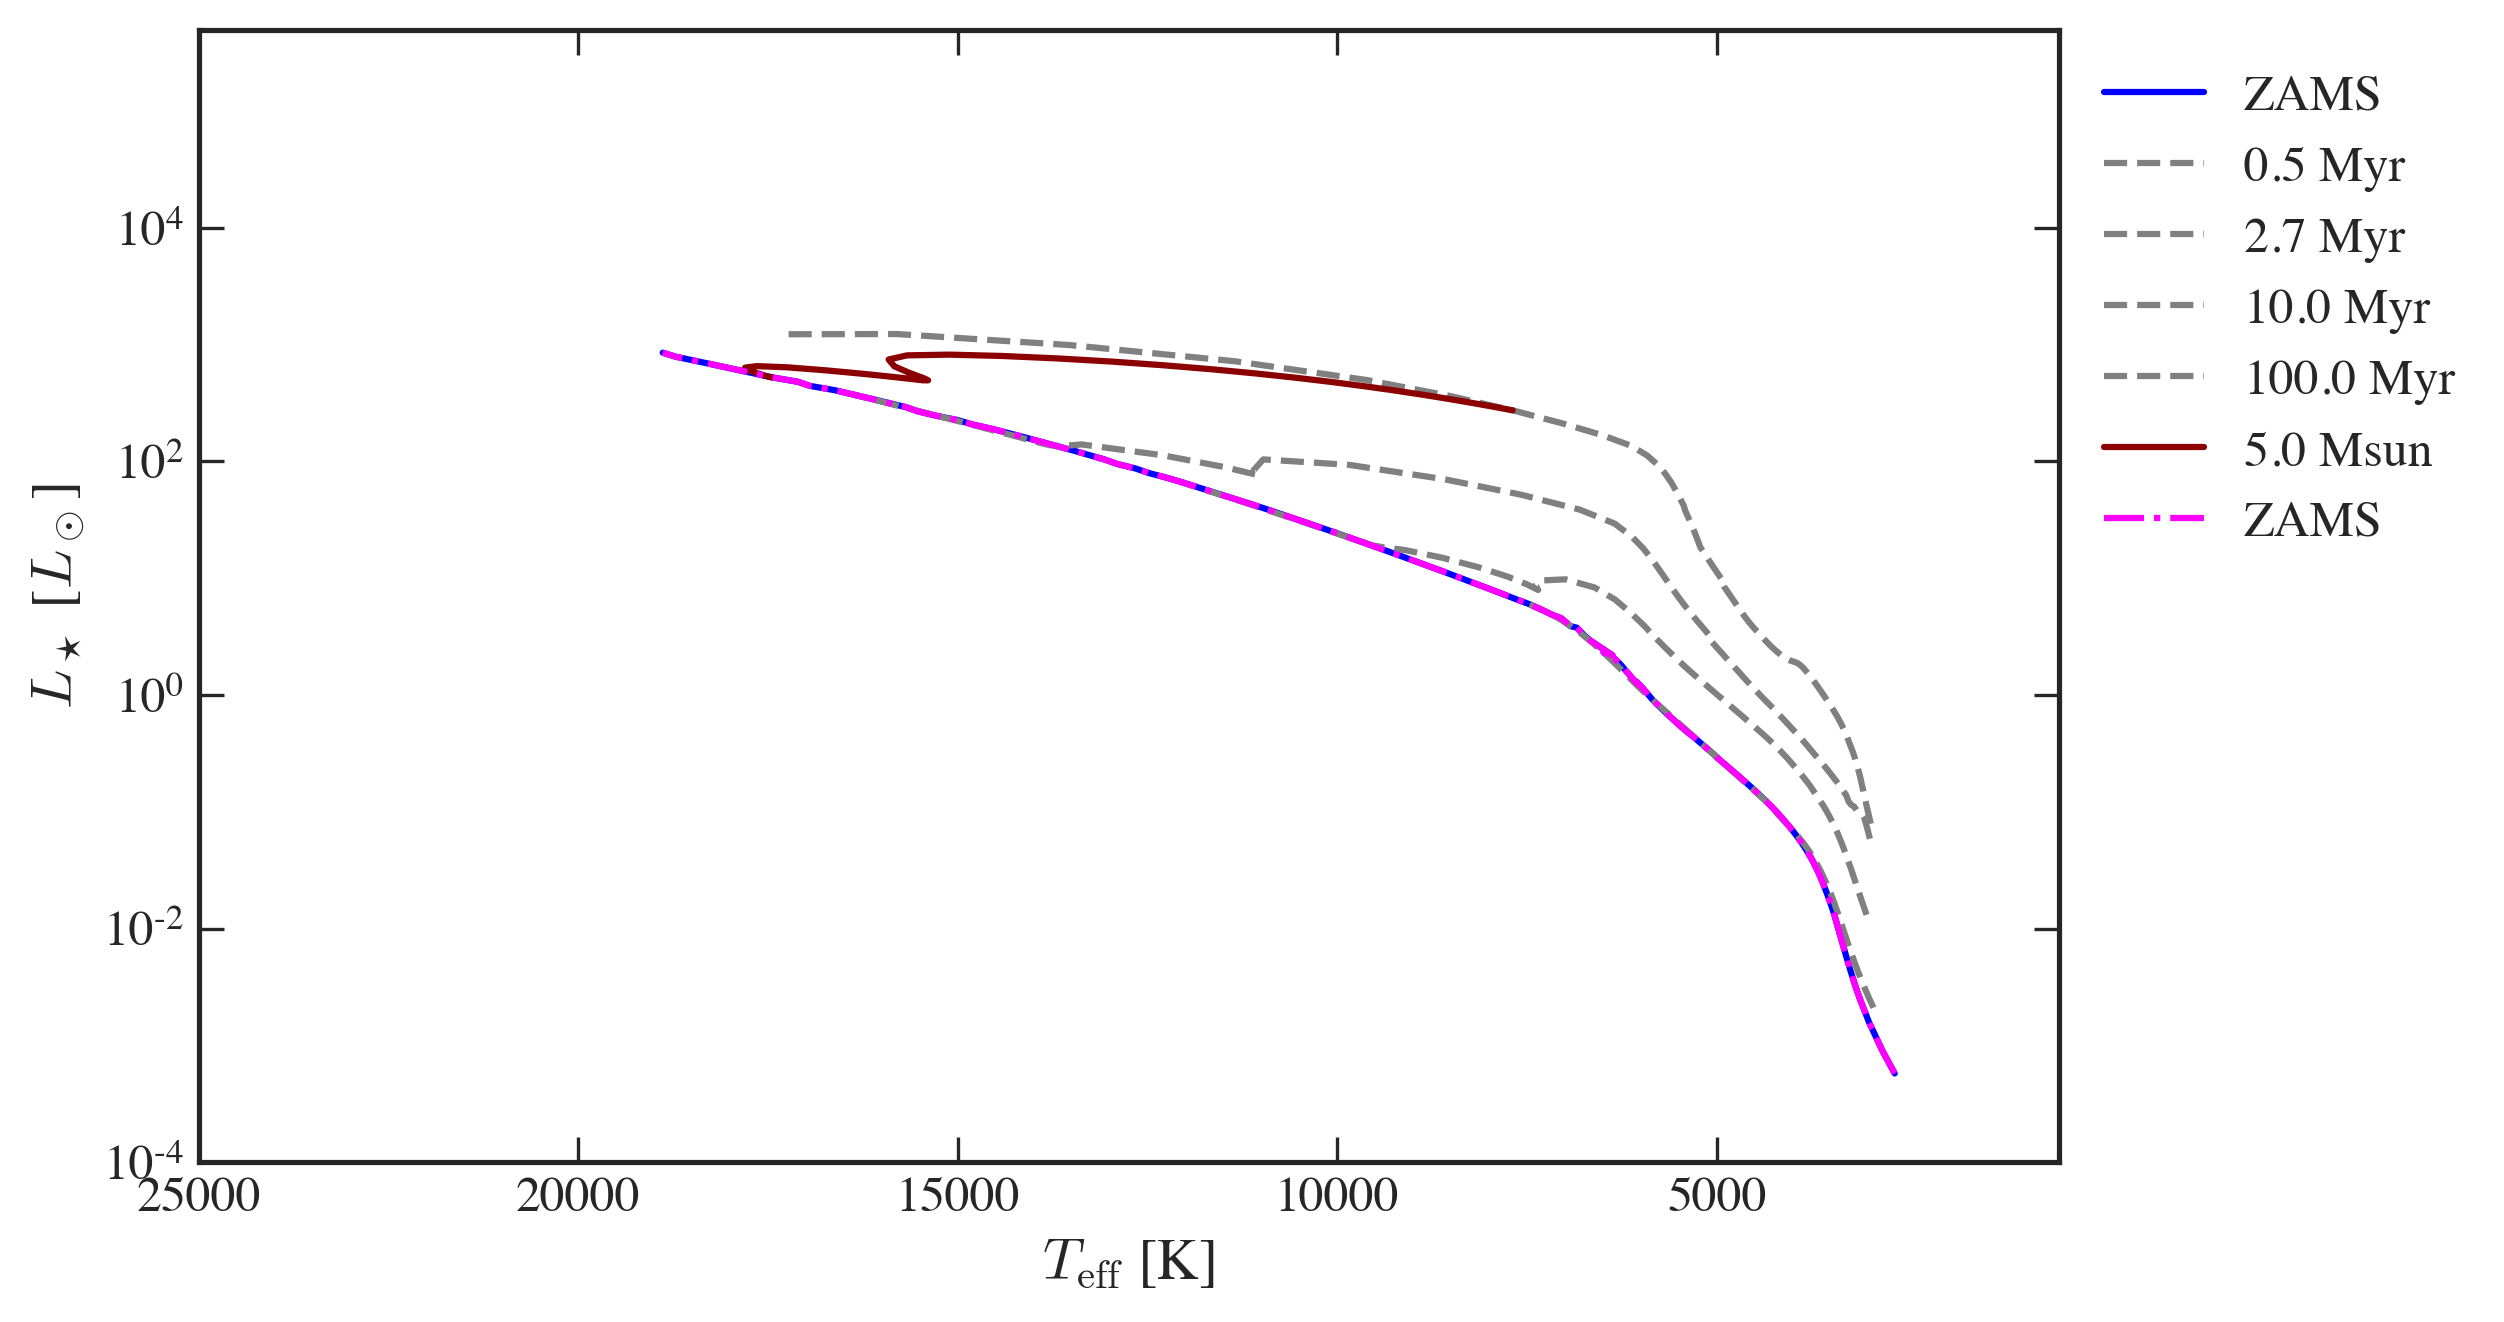

In [10]:
fig, axes = plt.subplots(1,1,figsize=(8, 5))

ax = axes

# Plot ZAMS curve
ax.plot(teff_zams, lum_zams, 'b-', label='ZAMS')

# Apply the mask to your plotting code
teff_iso = 10**isochrone.logtlogl[:, :, 0]  # Teff
lum_iso = 10**isochrone.logtlogl[:, :, 1]   # L/Lo

for age in [0.5e6, 2.7e6, 10.0e6, 100.0e6]:  # Example isochrone ages to plot
    idx_age = np.nanargmin(np.abs(isochrone.log_age - np.log10(age)))  # Find the closest age

    # Filter out Teff and Luminosity using the pre-main-sequence mask
    teff_filtered = teff_iso[idx_age, :][mask_pms[idx_age, :]]
    lum_filtered = lum_iso[idx_age, :][mask_pms[idx_age, :]]

    # Plot the pre-main-sequence part of the isochrone
    ax.plot(teff_filtered, lum_filtered, '--', label=f'{age/1e6:.1f} Myr', color='grey')

# Plot the mass tracks as well (like you already have)
for mass in [5.0]: # 0.5, 1.0, 1.2, 1.4, 2.0, 3.0, 5.0, 10.0, 
    idx_mass = np.nanargmin(np.abs(isochrone.masses - mass))  # Find closest mass
    teff_filtered = teff_iso[:, idx_mass][mask_pms[:, idx_mass]]
    lum_filtered = lum_iso[:, idx_mass][mask_pms[:, idx_mass]]
    # ax.plot(teff_iso[:, idx_mass], lum_iso[:, idx_mass], label=f'{mass:.1f} Msun', color='pink')
    ax.plot(teff_filtered, lum_filtered, '-', label=f'{mass:.1f} Msun', color='darkred')
    
ysoisochrone.plotting.plot_hr_diagram(isochrone, ax_set=ax, 
                                      ages_to_plot=[], 
                                      masses_to_plot=[],
                                      xlim_set=[2.5e4, 500], ylim_set=[1e-4, 5e5])

plt.show()

In [98]:
# for age in [5e7]:  # Example isochrone ages to plot
#     idx_age = np.nanargmin(np.abs(isochrone.log_age - np.log10(age)))  # Find the closest age

#     # Filter out Teff and Luminosity using the pre-main-sequence mask
#     teff_filtered = teff_iso[idx_age, :][mask_pms[idx_age, :]]
#     lum_filtered = lum_iso[idx_age, :][mask_pms[idx_age, :]]

the hrd for all

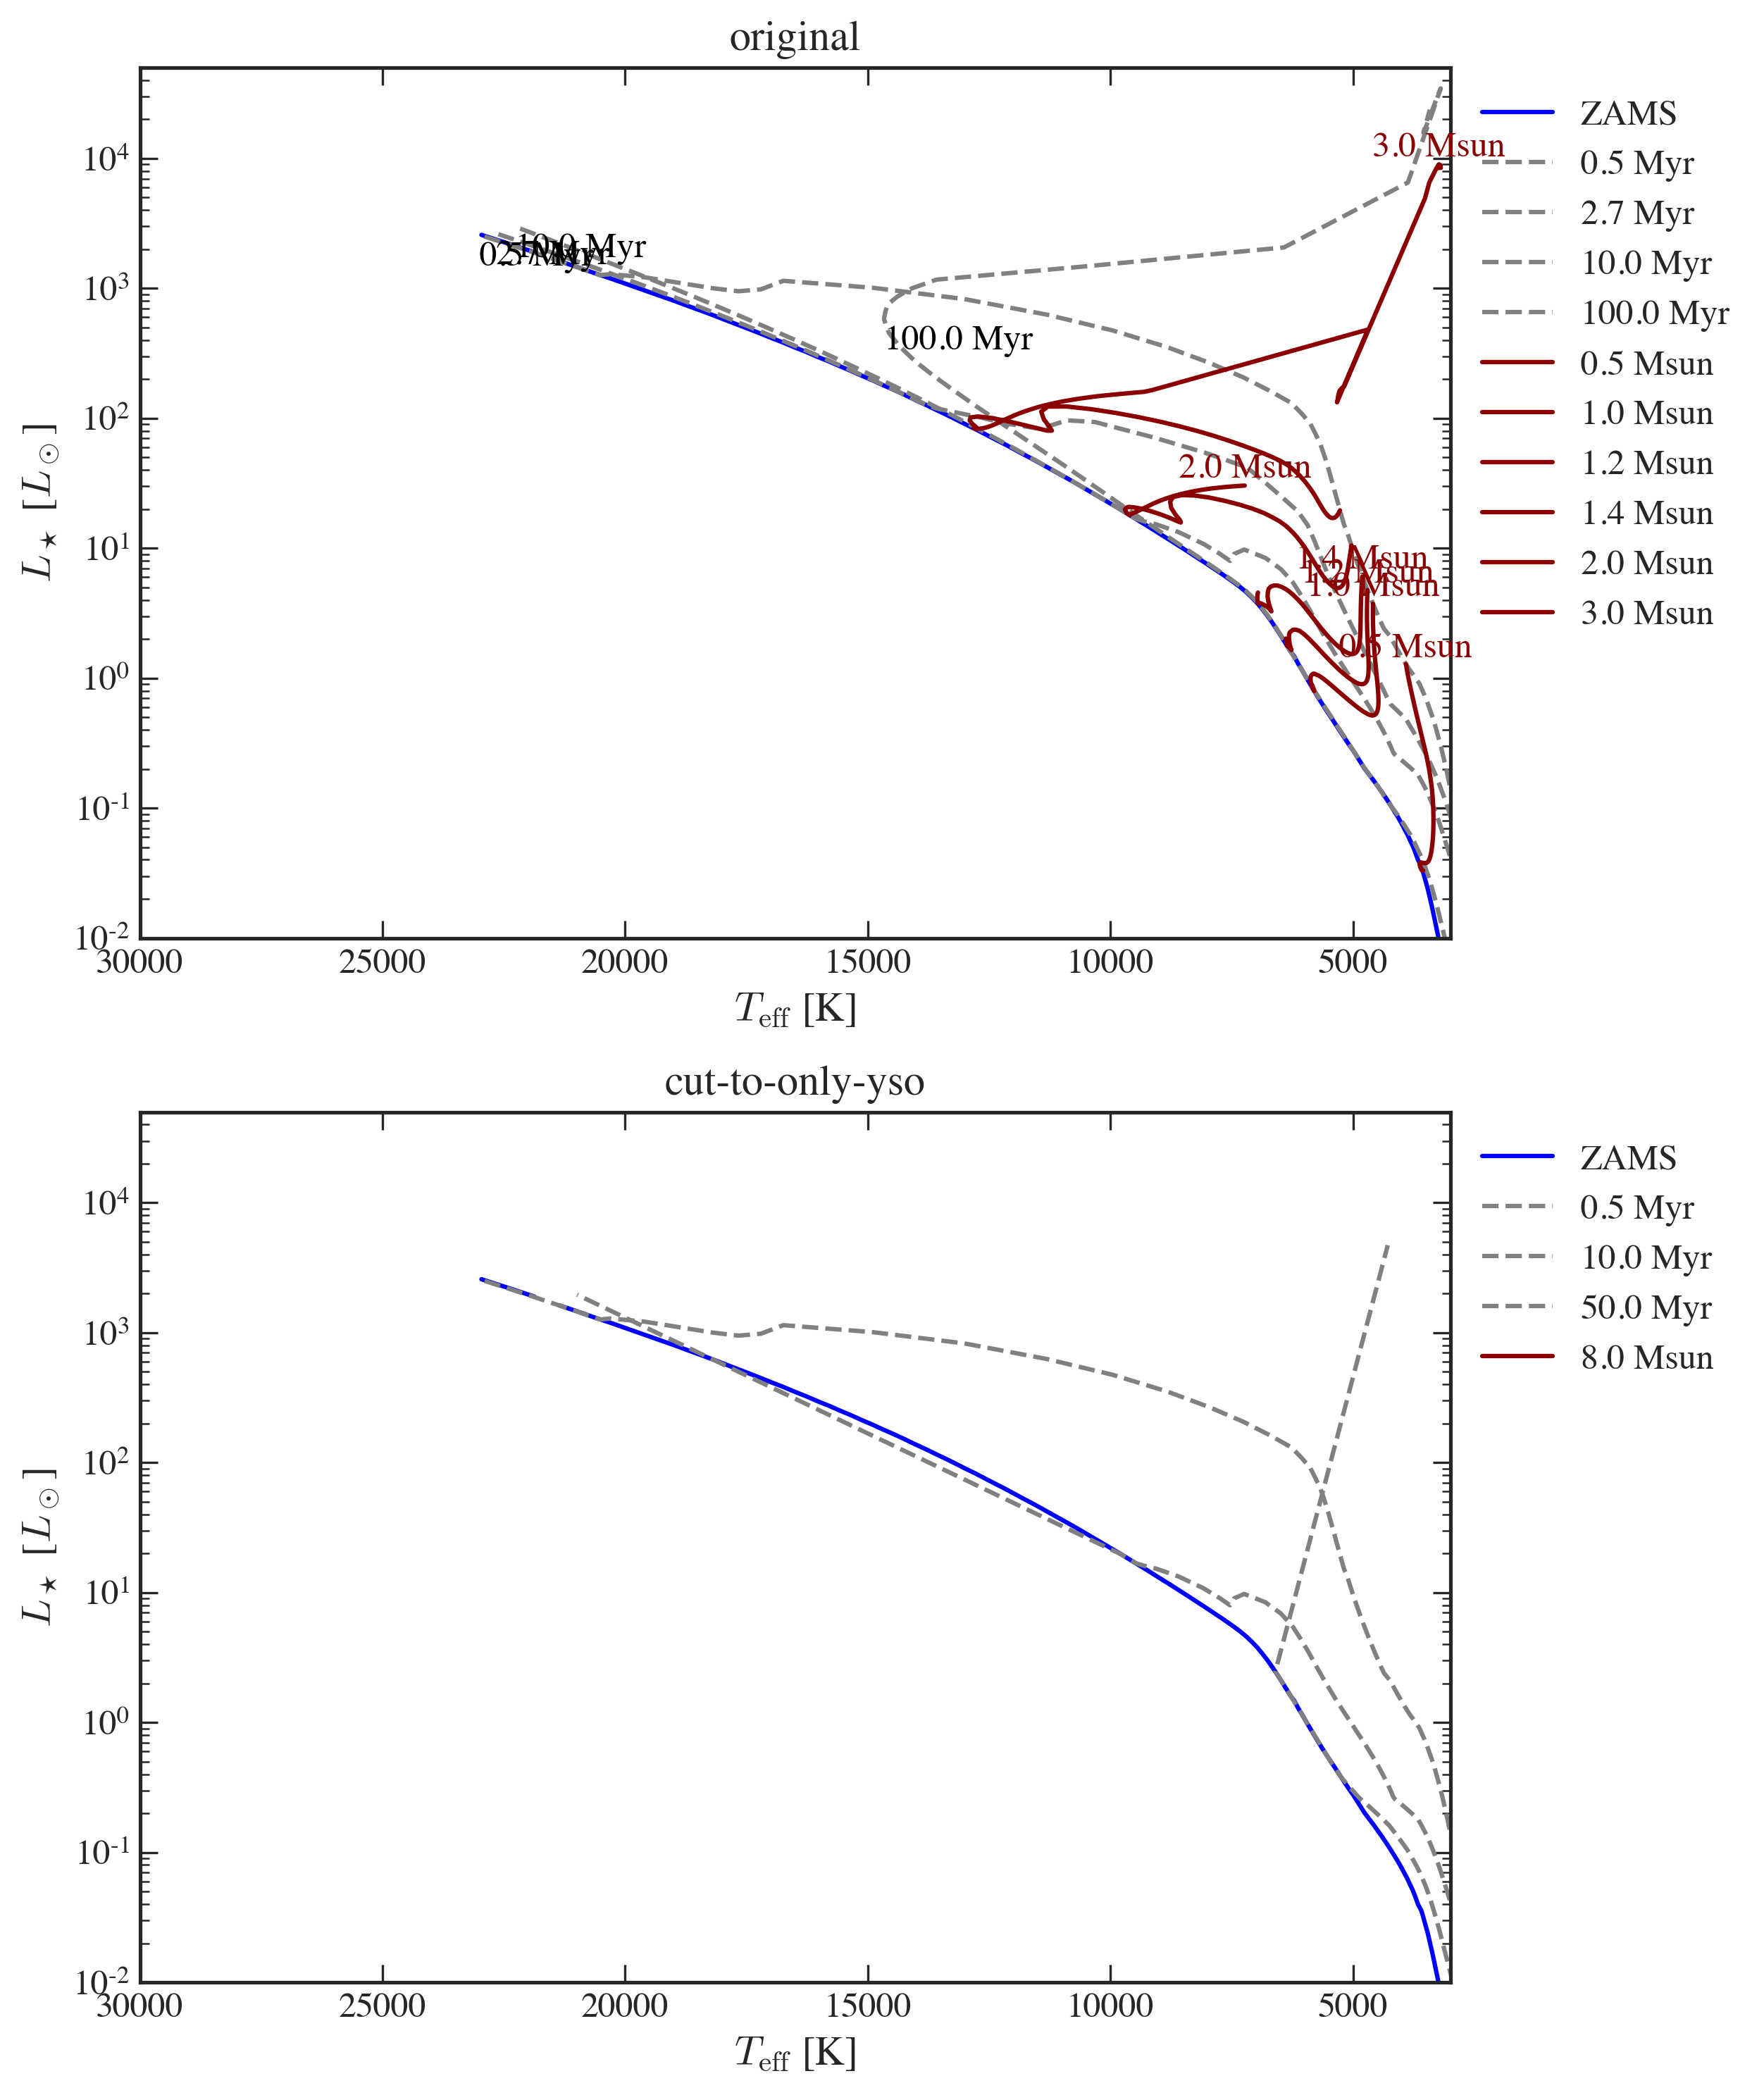

In [71]:
fig, axes = plt.subplots(2,1,figsize=(8, 12))

ax = axes[0]

ax.set_title('original')

# Plot ZAMS curve
ax.plot(teff_zams, lum_zams, 'b-', label='ZAMS')

# ysoisochrone.plotting.plot_hr_diagram(isochrone, ax_set=ax, 
#                                       ages_to_plot=[0.5e6, 1.0e6, 2.0e6, 3.0e6, 5.0e6, 10.0e6, 30.0e6, 100.0e6], 
#                                       masses_to_plot=[0.2, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.39],
#                                       xlim_set=[6000, 3000], ylim_set=[0.01, 50.0])

ysoisochrone.plotting.plot_hr_diagram(isochrone, ax_set=ax, 
                                      ages_to_plot=[0.5e6, 2.7e6, 10.0e6, 100.0e6], 
                                      masses_to_plot=[0.5, 1.0, 1.2, 1.4, 2.0, 3.0],
                                      xlim_set=[3e4, 3000], ylim_set=[0.01, 5e4])

ax = axes[1]

ax.set_title('cut-to-only-yso')

# Plot ZAMS curve
ax.plot(teff_zams, lum_zams, 'b-', label='ZAMS')

# Apply the mask to your plotting code
teff_iso = 10**isochrone.logtlogl[:, :, 0]  # Teff
lum_iso = 10**isochrone.logtlogl[:, :, 1]   # L/Lo

for age in [0.5e6, 1e7, 5e7]:  # Example isochrone ages to plot
    idx_age = np.nanargmin(np.abs(isochrone.log_age - np.log10(age)))  # Find the closest age

    # Filter out Teff and Luminosity using the pre-main-sequence mask
    teff_filtered = teff_iso[idx_age, :][mask_pms[idx_age, :]]
    lum_filtered = lum_iso[idx_age, :][mask_pms[idx_age, :]]

    # Plot the pre-main-sequence part of the isochrone
    ax.plot(teff_filtered, lum_filtered, '--', label=f'{age/1e6:.1f} Myr', color='grey')

# Plot the mass tracks as well (like you already have)
for mass in [8.0]: # 0.5, 1.0, 1.2, 1.4, 2.0, 3.0, 5.0, 10.0, 
    idx_mass = np.nanargmin(np.abs(isochrone.masses - mass))  # Find closest mass
    teff_filtered = teff_iso[:, idx_mass][mask_pms[:, idx_mass]]
    lum_filtered = lum_iso[:, idx_mass][mask_pms[:, idx_mass]]
    ax.plot(teff_filtered, lum_filtered, '-', label=f'{mass:.1f} Msun', color='darkred')
    
ysoisochrone.plotting.plot_hr_diagram(isochrone, ax_set=ax, 
                                      ages_to_plot=[], 
                                      masses_to_plot=[],
                                      xlim_set=[3e4, 3000], ylim_set=[0.01, 5e4])

plt.show()

other diagnostic plot

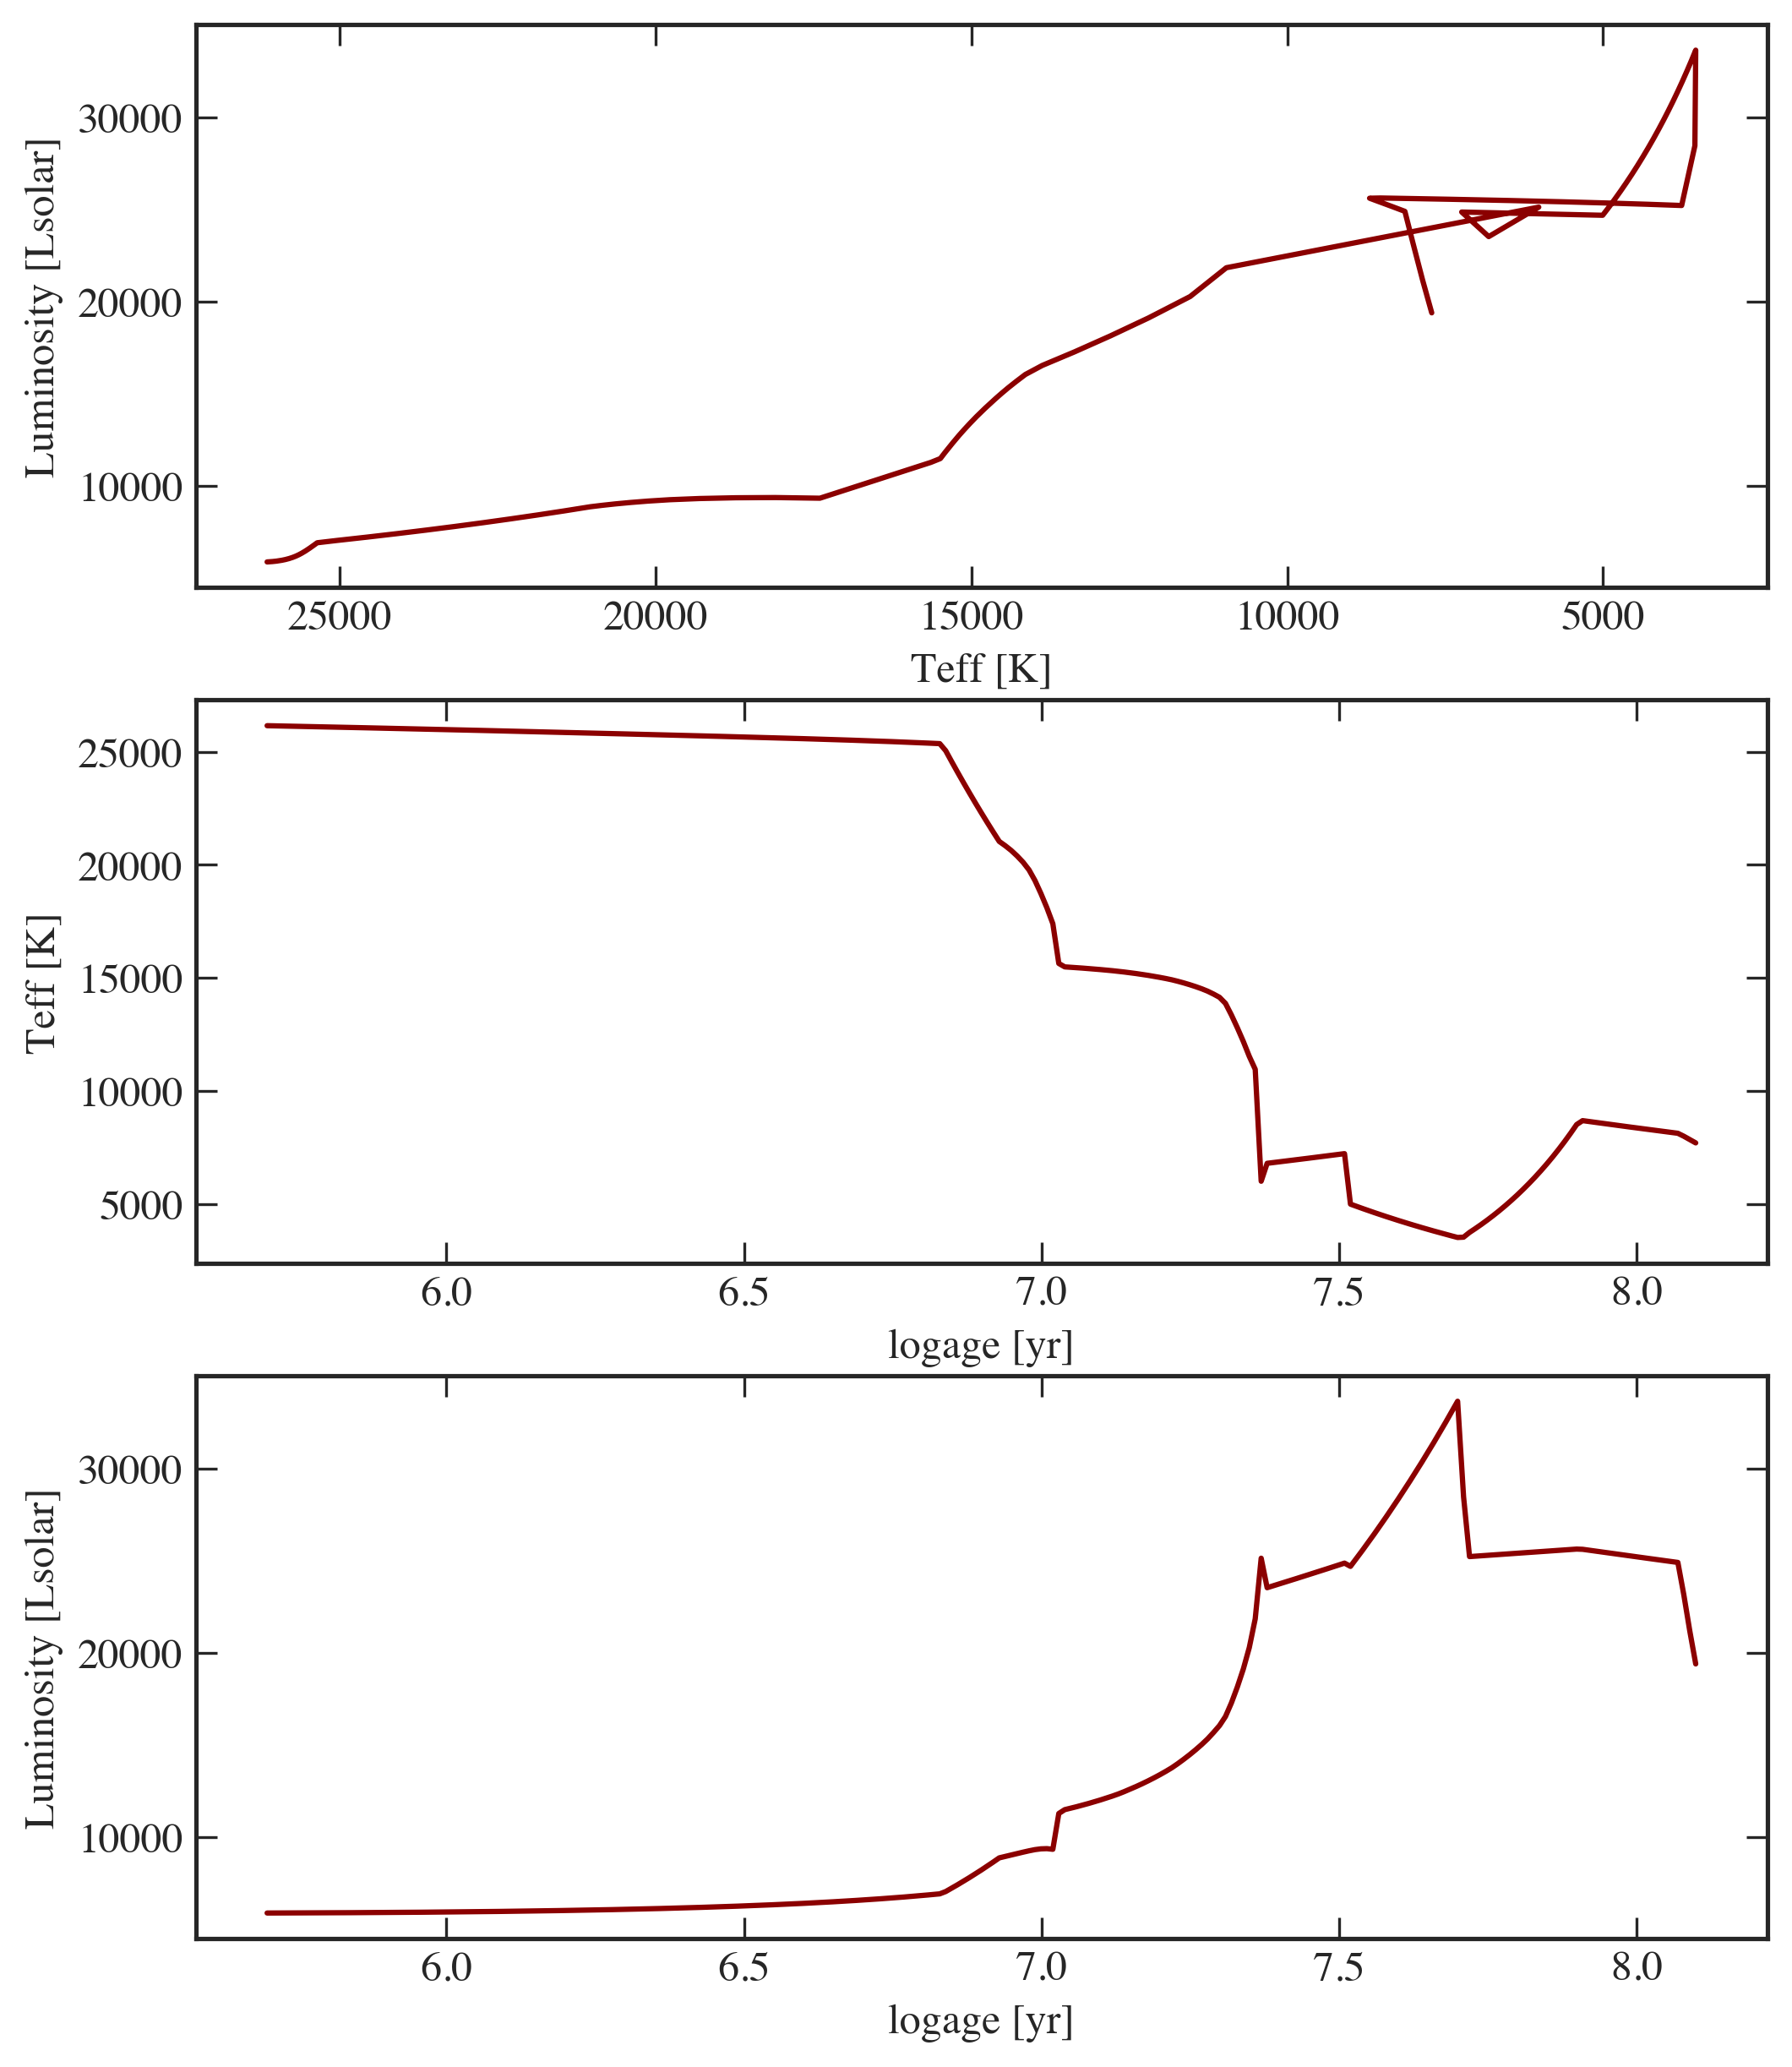

In [128]:
fig, axes = plt.subplots(3, 1, figsize=(8, 10))

teff_iso = 10**isochrone.logtlogl[:, :, 0]  # Teff
lum_iso = 10**isochrone.logtlogl[:, :, 1]   # L/Lo
mass = 10 # solar masses
idx_mass = np.nanargmin(np.abs(isochrone.masses - mass))  # Find closest mass

ax = axes[0]
ax.plot(teff_iso[:, idx_mass], lum_iso[:, idx_mass], '-', label=f'{mass:.1f} Msun', color='darkred')

ax.set_xlabel('Teff [K]')
ax.set_ylabel('Luminosity [Lsolar]')

ax.invert_xaxis()
# ax.set_yscale('log')

ax = axes[1]
ax.plot(isochrone.log_age, teff_iso[:, idx_mass], '-', label=f'{mass:.1f} Msun', color='darkred')

ax.set_xlabel('logage [yr]')
ax.set_ylabel('Teff [K]')
# ax.set_ylabel('Luminosity [Lsolar]')

# ax.set_yscale('log')

ax = axes[2]
ax.plot(isochrone.log_age, lum_iso[:, idx_mass], '-', label=f'{mass:.1f} Msun', color='darkred')

ax.set_xlabel('logage [yr]')
ax.set_ylabel('Luminosity [Lsolar]')

# ax.set_yscale('log')

plt.show()

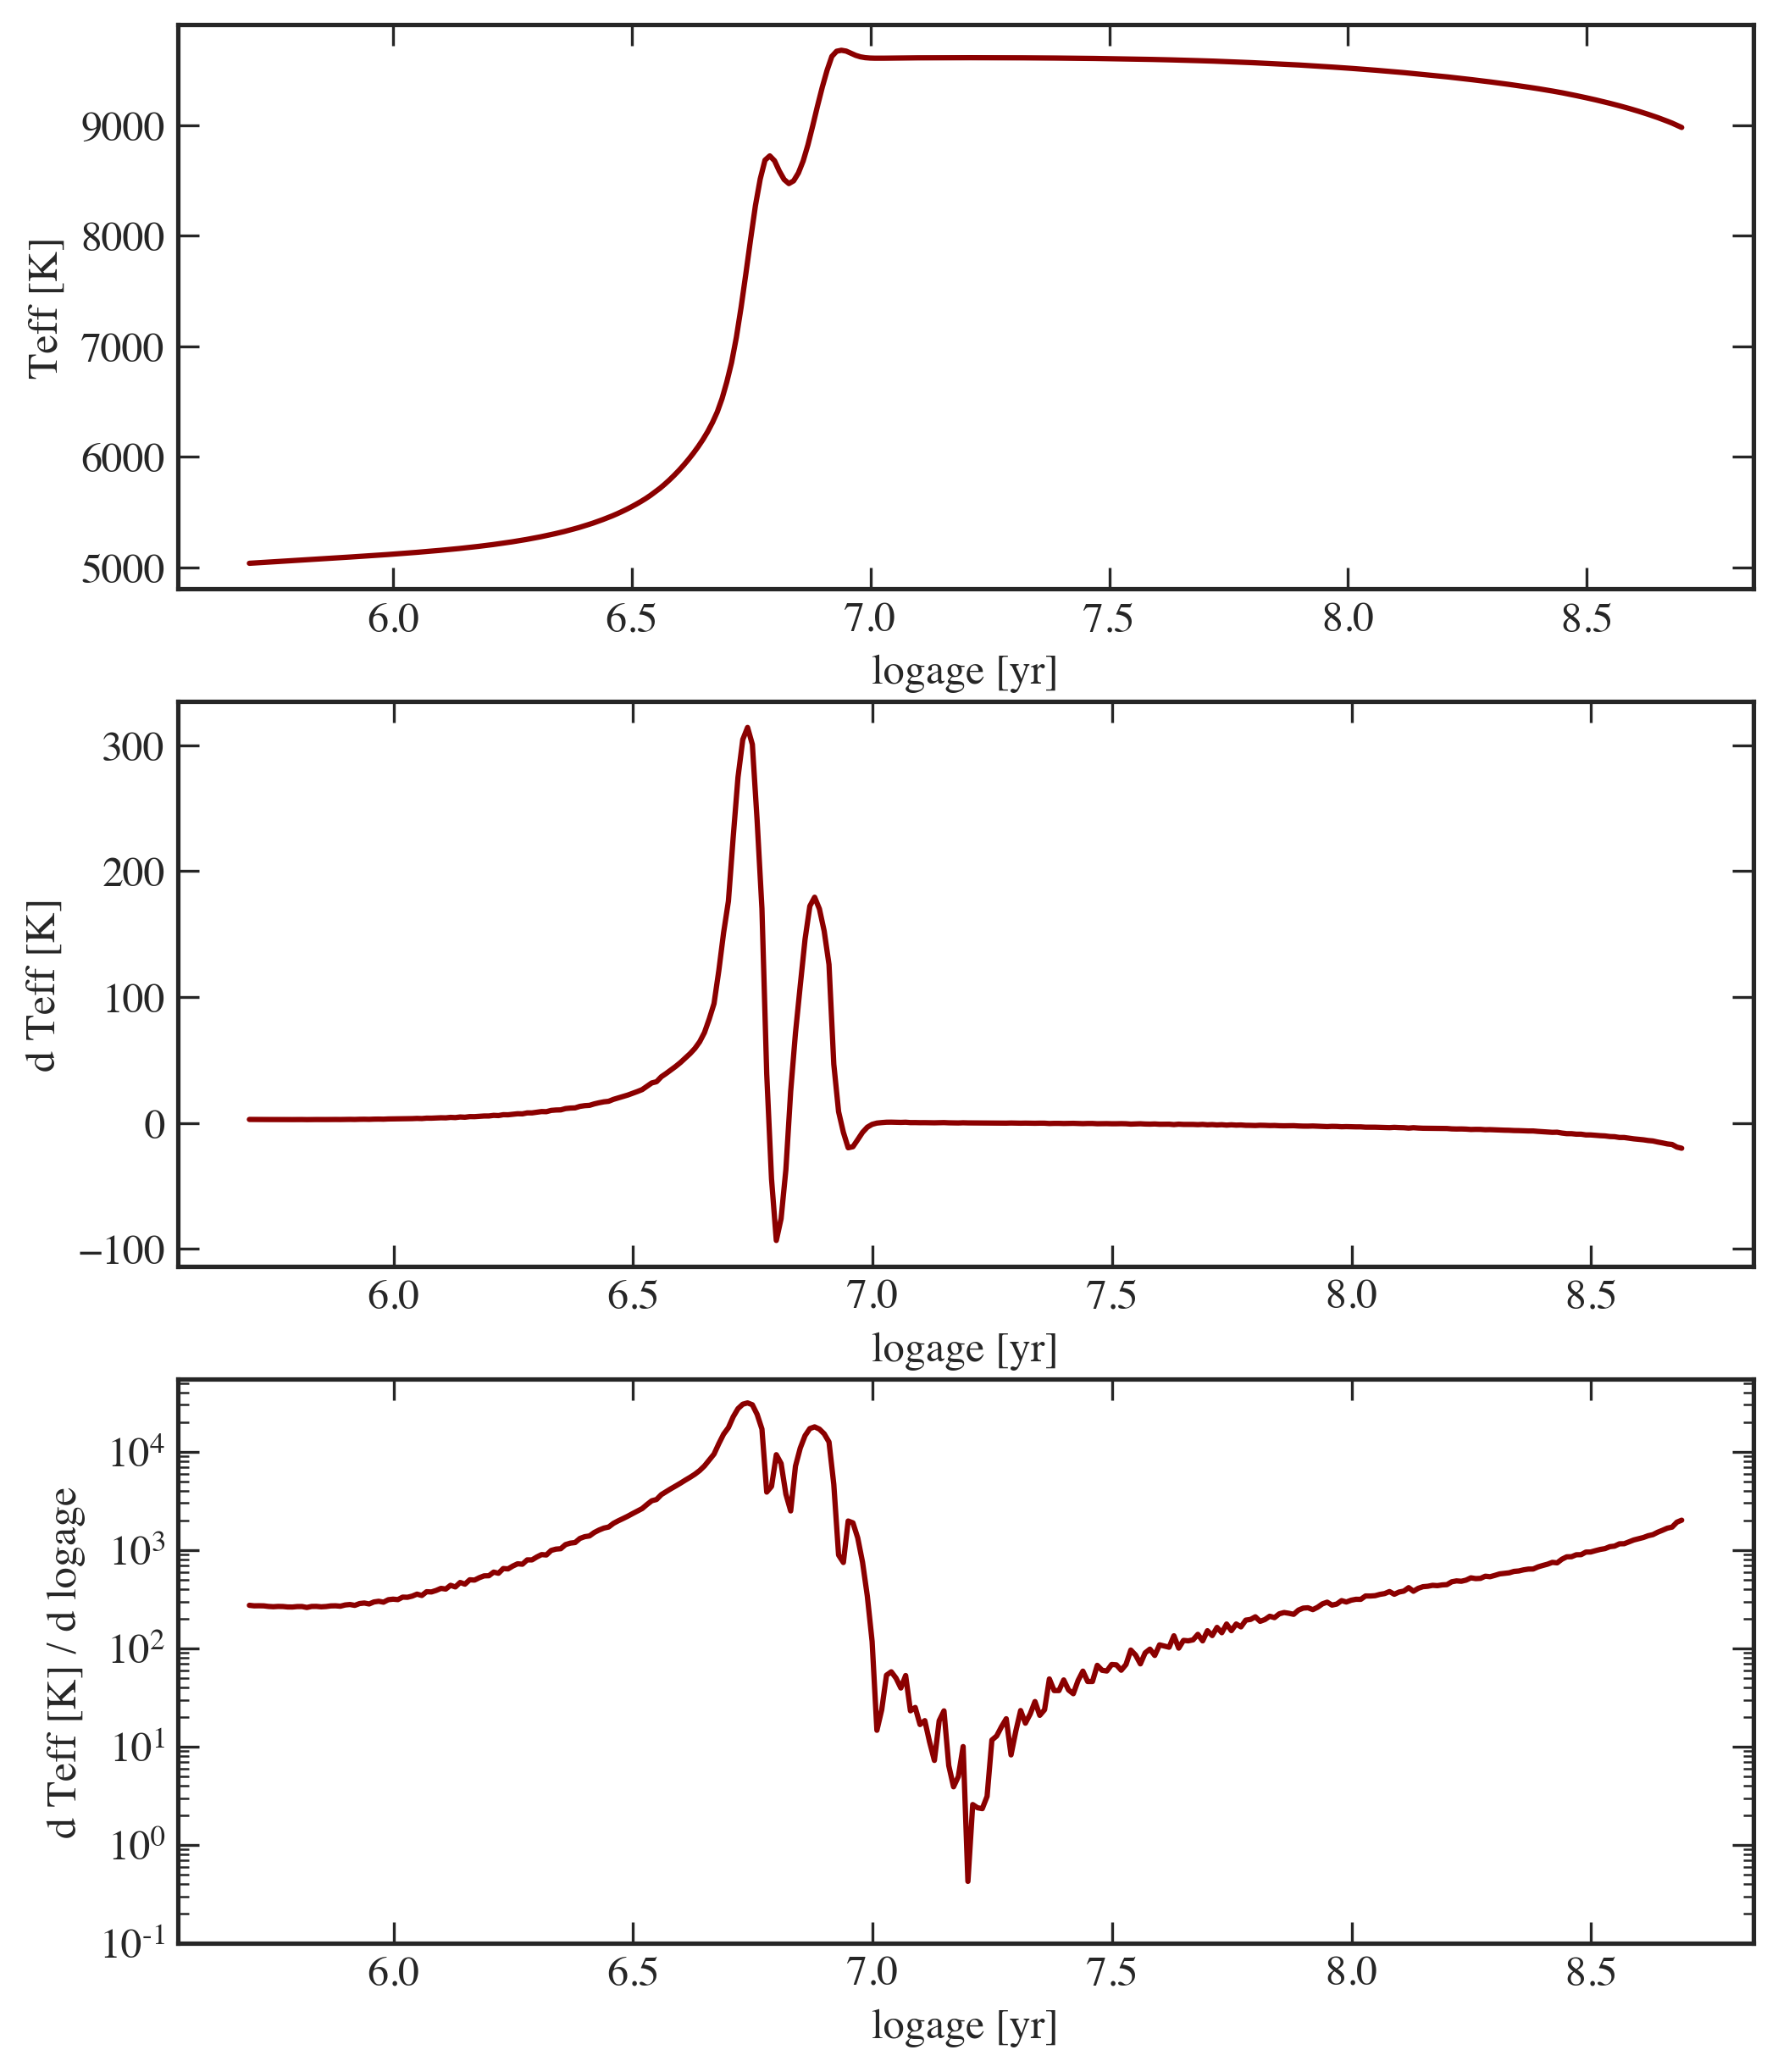

In [87]:
fig, axes = plt.subplots(3, 1, figsize=(8, 10))

teff_iso = 10**isochrone.logtlogl[:, :, 0]  # Teff
lum_iso = 10**isochrone.logtlogl[:, :, 1]   # L/Lo
mass = 2.0 # solar masses
idx_mass = np.nanargmin(np.abs(isochrone.masses - mass))  # Find closest mass

ax = axes[0]
ax.plot(isochrone.log_age, teff_iso[:, idx_mass], '-', label=f'{mass:.1f} Msun', color='darkred')

ax.set_xlabel('logage [yr]')
ax.set_ylabel('Teff [K]')
# ax.set_ylabel('Luminosity [Lsolar]')

# ax.set_yscale('log')

ax = axes[1]
ax.plot(isochrone.log_age[:-1], np.diff(teff_iso[:, idx_mass]), '-', label=f'{mass:.1f} Msun', color='darkred')

ax.set_xlabel('logage [yr]')
ax.set_ylabel('d Teff [K]')
# ax.set_ylabel('Luminosity [Lsolar]')

# ax.set_yscale('log')

ax = axes[2]
ax.plot(isochrone.log_age[:-1], np.abs(np.diff(teff_iso[:, idx_mass])/np.diff(isochrone.log_age)), '-', label=f'{mass:.1f} Msun', color='darkred')

ax.set_xlabel('logage [yr]')
ax.set_ylabel('d Teff [K] / d logage')
# ax.set_ylabel('Luminosity [Lsolar]')

ax.set_yscale('log')
ax.set_ylim(1e-1, )

plt.show()